<div style="width:100%; height:140px">
    <img src="https://www.kuleuven.be/internationaal/thinktank/fotos-en-logos/ku-leuven-logo.png/image_preview" width = 300px, heigh = auto align=left>
</div>


KUL H02A5a Computer Vision: Group Assignment 2
---------------------------------------------------------------
Student numbers: r0703889, r0909802, r0716758, r0916443, r0822692.

In this group assignment your team will delve into some deep learning applications for computer vision. The assignment will be delivered in the same groups from *Group assignment 1* and you start from this template notebook. The notebook you submit for grading is the last notebook you submit in the [Kaggle competition](https://www.kaggle.com/t/d11be6a431b84198bc85f54ae7e2563f) prior to the deadline on **Tuesday 24 May 23:59**. Closely follow [these instructions](https://github.com/gourie/kaggle_inclass) for joining the competition, sharing your notebook with the TAs and making a valid notebook submission to the competition. A notebook submission not only produces a *submission.csv* file that is used to calculate your competition score, it also runs the entire notebook and saves its output as if it were a report. This way it becomes an all-in-one-place document for the TAs to review. As such, please make sure that your final submission notebook is self-contained and fully documented (e.g. provide strong arguments for the design choices that you make). Most likely, this notebook format is not appropriate to run all your experiments at submission time (e.g. the training of CNNs is a memory hungry and time consuming process; due to limited Kaggle resources). It can be a good idea to distribute your code otherwise and only summarize your findings, together with your final predictions, in the submission notebook. For example, you can substitute experiments with some text and figures that you have produced "offline" (e.g. learning curves and results on your internal validation set or even the test set for different architectures, pre-processing pipelines, etc). We advise you to first go through the PDF of this assignment entirely before you really start. Then, it can be a good idea to go through this notebook and use it as your first notebook submission to the competition. You can make use of the *Group assignment 2* forum/discussion board on Toledo if you have any questions. Good luck and have fun!

---------------------------------------------------------------
NOTES:
* This notebook is just a template. Please keep the five main sections, but feel free to adjust further in any way you please!
* Clearly indicate the improvements that you make! You can for instance use subsections like: *3.1. Improvement: applying loss function f instead of g*.


# 1. Overview
This assignment consists of *three main parts* for which we expect you to provide code and extensive documentation in the notebook:
* Image classification (Sect. 2)
* Semantic segmentation (Sect. 3)
* Adversarial attacks (Sect. 4)

In the first part, you will train an end-to-end neural network for image classification. In the second part, you will do the same for semantic segmentation. For these two tasks we expect you to put a significant effort into optimizing performance and as such competing with fellow students via the Kaggle competition. In the third part, you will try to find and exploit the weaknesses of your classification and/or segmentation network. For the latter there is no competition format, but we do expect you to put significant effort in achieving good performance on the self-posed goal for that part. Finally, we ask you to reflect and produce an overall discussion with links to the lectures and "real world" computer vision (Sect. 5). It is important to note that only a small part of the grade will reflect the actual performance of your networks. However, we do expect all things to work! In general, we will evaluate the correctness of your approach and your understanding of what you have done that you demonstrate in the descriptions and discussions in the final notebook.

## 1.1 Deep learning resources
If you did not yet explore this in *Group assignment 1 (Sect. 2)*, we recommend using the TensorFlow and/or Keras library for building deep learning models. You can find a nice crash course [here](https://colab.research.google.com/drive/1UCJt8EYjlzCs1H1d1X0iDGYJsHKwu-NO).

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
import numpy as np
import pandas as pd
import tensorflow as tf
from matplotlib import pyplot as plt

## 1.2 PASCAL VOC 2009
For this project you will be using the [PASCAL VOC 2009](http://host.robots.ox.ac.uk/pascal/VOC/voc2009/index.html) dataset. This dataset consists of colour images of various scenes with different object classes (e.g. animal: *bird, cat, ...*; vehicle: *aeroplane, bicycle, ...*), totalling 20 classes.

The training set contains 749 examples.


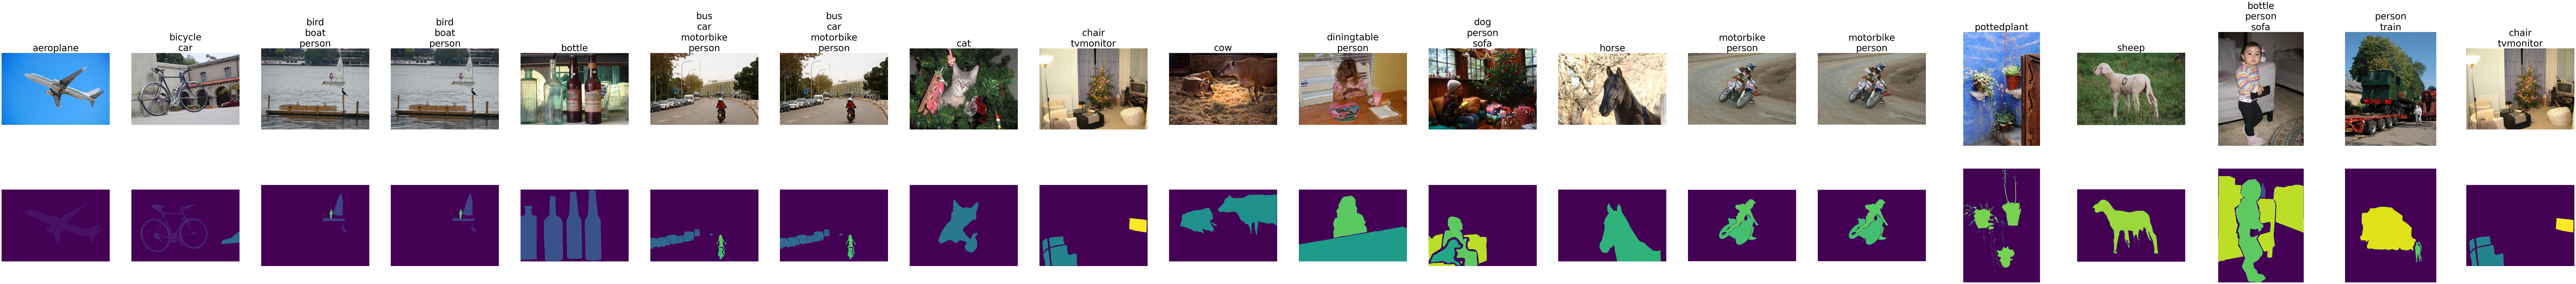

aeroplane  bicycle  bird  boat  bottle  bus  car  cat  chair  cow  ...  \
Id                                                                     ...   
0           0        0     0     0       0    0    0    0      0    1  ...   

    horse  motorbike  person  pottedplant  sheep  sofa  train  tvmonitor  \
Id                                                                         
0       0          0       0            0      0     0      0          0   

                                                  img  \
Id                                                      
0   [[[10, 8, 13], [16, 14, 19], [17, 14, 21], [19...   

                                                  seg  
Id                                                     
0   [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...  

[1 rows x 22 columns]

In [2]:
# Loading the training data
train_df = pd.read_csv('./kaggle/input/kul-h02a5a-computer-vision-ga2-2022/train/train_set.csv', index_col="Id")
labels = train_df.columns
train_df["img"] = [np.load('./kaggle/input/kul-h02a5a-computer-vision-ga2-2022/train/img/train_{}.npy'.format(idx)) for idx, _ in train_df.iterrows()]
train_df["seg"] = [np.load('./kaggle/input/kul-h02a5a-computer-vision-ga2-2022/train/seg/train_{}.npy'.format(idx)) for idx, _ in train_df.iterrows()]
print("The training set contains {} examples.".format(len(train_df)))

# Show some examples
fig, axs = plt.subplots(2, 20, figsize=(10 * 20, 10 * 2))
for i, label in enumerate(labels):
    df = train_df.loc[train_df[label] == 1]
    axs[0, i].imshow(df.iloc[0]["img"], vmin=0, vmax=255)
    axs[0, i].set_title("\n".join(label for label in labels if df.iloc[0][label] == 1), fontsize=40)
    axs[0, i].axis("off")
    axs[1, i].imshow(df.iloc[0]["seg"], vmin=0, vmax=20)  # with the absolute color scale it will be clear that the arrays in the "seg" column are label maps (labels in [0, 20])
    axs[1, i].axis("off")
    
plt.show()

# The training dataframe contains for each image 20 columns with the ground truth classification labels and 20 column with the ground truth segmentation maps for each class
train_df.head(1)

In [3]:
# Loading the test data
test_df = pd.read_csv('./kaggle/input/kul-h02a5a-computer-vision-ga2-2022/test/test_set.csv', index_col="Id")
test_df["img"] = [np.load('./kaggle/input/kul-h02a5a-computer-vision-ga2-2022/test/img/test_{}.npy'.format(idx)) for idx, _ in test_df.iterrows()]
test_df["seg"] = [-1 * np.ones(img.shape[:2], dtype=np.int8) for img in test_df["img"]]
print("The test set contains {} examples.".format(len(test_df)))

# The test dataframe is similar to the training dataframe, but here the values are -1 --> your task is to fill in these as good as possible in Sect. 2 and Sect. 3; in Sect. 6 this dataframe is automatically transformed in the submission CSV!
test_df.head(1)

The test set contains 750 examples.


aeroplane  bicycle  bird  boat  bottle  bus  car  cat  chair  cow  ...  \
Id                                                                     ...   
0          -1       -1    -1    -1      -1   -1   -1   -1     -1   -1  ...   

    horse  motorbike  person  pottedplant  sheep  sofa  train  tvmonitor  \
Id                                                                         
0      -1         -1      -1           -1     -1    -1     -1         -1   

                                                  img  \
Id                                                      
0   [[[139, 130, 115], [136, 127, 112], [112, 102,...   

                                                  seg  
Id                                                     
0   [[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, ...  

[1 rows x 22 columns]

# Preprocessing

In [4]:
import cv2

In [12]:
class Preprocessor:
    
    def __init__(self,img_size):
        self.img_size=img_size
        self.width = self.img_size[1]
        self.height = self.img_size[0]
        # TODO: gray or not gray
        # Train/test
        
    def resize(self,img):
        resized = cv2.resize(img, (self.width,self.height, 3), interpolation = cv2.INTER_AREA)
        return resized
    
    def normalization(self,gray_img):
        img = gray_img / 255.0
        return img
    
    def Filter(self,img,filter):
        if filter=='Gaussian':
            img = cv2.GaussianBlur(img,(5,5),cv2.BORDER_DEFAULT)
        elif filter=='Median':
            img = cv2.medianBlur(img,5)
        else:
            raise Error
            
        return img
    
    def preprocess(self,data):
        images = data["img"]
        segmentations = data["seg"]
        nb_images = images.shape[0]
        for i in range(nb_images):
            image = images[i]
            seg = segmentations[i]
            # Resize both img and seg
            image = self.resize(image)
            seg = self.resize(seg)
            # Switch to grayscale
            #gray_img = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            # Normalization
            normalized_img = self.normalization(image)
            # Filter 
            blur_img = self.Filter(normalized_img,'Gaussian')
            img = tf.convert_to_tensor(blur_img)
            seg = tf.convert_to_tensor(seg)
            images[i]=img
            segmentations[i]=seg
        return images,segmentations
            
            
    
    def __call__(self, data):
        return self.preprocess(data)
        

def FindLargestDim(data):
    imgs = data['img']
    x_max = 0
    y_max = 0
    for img in imgs:
        x,y,_ = img.shape
        if x>x_max:
            x_max=x
        if y>y_max:
            y_max=y
    return (x_max,y_max)

In [13]:
# Step 2: balanced/unbalanced data
for i in range(len(train_df.columns)-2):
    arr = train_df[train_df.columns[i]].to_numpy()
    amount = np.count_nonzero(arr == 1)

    print('Number of', train_df.columns[i], ':', amount)

Number of aeroplane : 176
Number of bicycle : 81
Number of bird : 208
Number of boat : 171
Number of bottle : 123
Number of bus : 125
Number of car : 183
Number of cat : 174
Number of chair : 228
Number of cow : 99
Number of diningtable : 129
Number of dog : 151
Number of horse : 117
Number of motorbike : 119
Number of person : 207
Number of pottedplant : 145
Number of sheep : 105
Number of sofa : 158
Number of train : 148
Number of tvmonitor : 168


TODO: EXPLAIN: TOO MUCH PERSONS: AUGMENT ALL THE CLASSES EXCEPT PERSON (all x4)

DATA AUGMENTATION

In [14]:
data_except_person = train_df['aeroplane']

print(data_except_person)

0       0
1       0
2       0
3       0
4       0
       ..
2370    0
2371    0
2372    0
2373    0
2374    0
Name: aeroplane, Length: 2375, dtype: int64


In [ ]:
pp = labels.get_loc("person") ##Position person
for i in range(train_df["img"].shape[0]):
    select= train_df.loc[i]
    if select[labels[pp]]==0:
        
        FLR = select.copy()
        FLR["img"] = np.array(tf.image.flip_left_right(FLR["img"]))
        FLR["seg"] = np.array(tf.image.flip_left_right(tf.expand_dims(FLR["seg"],axis=2)))
        train_df = train_df.append(FLR,ignore_index=True)
        
        FUD = select.copy()
        FUD["img"] = np.array(tf.image.flip_up_down(FUD["img"]))
        FUD["seg"] = np.array(tf.image.flip_up_down(tf.expand_dims(FUD["seg"],axis=2)))
        train_df = train_df.append(FUD,ignore_index=True)
        
        B = select.copy()
        B["img"] = np.array(tf.image.random_brightness(B["img"],0.6, seed=None))
        train_df = train_df.append(B,ignore_index=True)
        
# train_df
            

In [ ]:
dim = FindLargestDim(train_df)
preprocessor = Preprocessor(dim)
images,segmentations = preprocessor(train_df)

print(preprocessor)
#print(train_df["img"][2].shape)

tf.float64

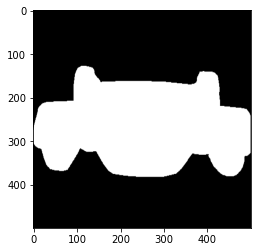

In [10]:
plt.imshow(train_df["seg"][2034], cmap="gray")

train_df["img"][2].dtype

In [13]:
for i in range(len(train_df.columns)-2):
    arr = train_df[train_df.columns[i]].to_numpy()
    amount = np.count_nonzero(arr == 1)

    print('NEW: Number of', train_df.columns[i], ':', amount)

NEW: Number of aeroplane : 176
NEW: Number of bicycle : 81
NEW: Number of bird : 208
NEW: Number of boat : 171
NEW: Number of bottle : 123
NEW: Number of bus : 125
NEW: Number of car : 183
NEW: Number of cat : 174
NEW: Number of chair : 228
NEW: Number of cow : 99
NEW: Number of diningtable : 129
NEW: Number of dog : 151
NEW: Number of horse : 117
NEW: Number of motorbike : 119
NEW: Number of person : 207
NEW: Number of pottedplant : 145
NEW: Number of sheep : 105
NEW: Number of sofa : 158
NEW: Number of train : 148
NEW: Number of tvmonitor : 168


(500, 500, 3)


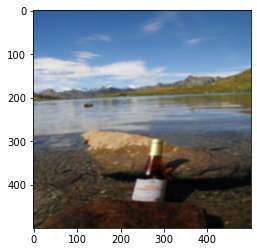

In [14]:
plt.imshow(train_df["img"][2])
print(train_df["img"][2].shape)

### putting data in datastructures which can be used in the machine learning models

#### training data

In [15]:
# output is a so called one-hot encoding
# one-hot encoding can be used when as loss the categorical-entropy wordt gebruikt
y = train_df[['aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike', 'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor']]
train_y = y.to_numpy()
print(train_y)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 1 ... 0 0 0]
 [0 0 1 ... 0 0 0]
 [0 0 1 ... 0 0 0]]


In [18]:
# reshape images 
# input images should have a shape [batch_size, img_height, img_width, number_of_channels]
numberOfIm = len(train_df["img"])
train_x = np.array(np.zeros([numberOfIm, 500, 500, 3]))
for i in range(numberOfIm):
    Im = train_df["img"][i]
    A = np.asarray(Im).reshape(500,500,3)
    train_x[i,:,:,:] = A

In [19]:
print(train_x.shape)
print(train_y.shape)

(2375, 500, 500, 3)
(2375, 20)


In [ ]:
#train_x_3_channel = []

# TODO: SOLVE BECAUSE BUG: CRASHES IF ON WHOLE DATASET
#for i in range(3):
##    to_3_channels = train_x[i].repeat(3, axis=-1)
#    train_x_3_channel.append(to_3_channels)

#print(train_x_3_channel)

#### test data

In [29]:
class PreprocessorTest:
    
    def __init__(self,img_size):
        self.img_size=img_size
        self.width = self.img_size[1]
        self.height = self.img_size[0]
        
    def resize(self,img):
        print(img.shape)
        resized = cv2.resize(img, (self.width,self.height, 3), interpolation = cv2.INTER_AREA)
        print(resized.shape)
        return resized
    
    def normalization(self,gray_img):
        img = gray_img / 255.0
        return img
    
    def Filter(self,img,filter):
        if filter=='Gaussian':
            img = cv2.GaussianBlur(img,(5,5),cv2.BORDER_DEFAULT)
        elif filter=='Median':
            img = cv2.medianBlur(img,5)
        else:
            raise Error
            
        return img
    
    def preprocess(self,data):
        images = data["img"]
        nb_images = images.shape[0]
        for i in range(nb_images):
            image = images[i]
            # Resize both img and seg
            image = self.resize(image)
            # Switch to grayscale
            #gray_img = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            # Normalization
            normalized_img = self.normalization(image)
            # Filter 
            blur_img = self.Filter(normalized_img,'Gaussian')
            img = tf.convert_to_tensor(blur_img)
            images[i]=img
        return images
            
            
    
    def __call__(self, data):
        return self.preprocess(data)
        
# No change
def FindLargestDim(data):
    imgs = data['img']
    x_max = 0
    y_max = 0
    for img in imgs:
        x,y,_ = img.shape
        if x>x_max:
            x_max=x
        if y>y_max:
            y_max=y
    return (x_max,y_max)
    

In [30]:
dim = FindLargestDim(test_df)
print(dim)
preprocessor = PreprocessorTest(dim)
preprocessor.resize(train_df["img"][1])
#print(preprocessor.preprocess(test_df))
#images = preprocessor(test_df)

(500, 500)
(500, 500, 3)


error: OpenCV(4.5.5) :-1: error: (-5:Bad argument) in function 'resize'
> Overload resolution failed:
>  - src is not a numpy array, neither a scalar
>  - Expected Ptr<cv::UMat> for argument 'src'


In [18]:
print(test_df.head())

    aeroplane  bicycle  bird  boat  bottle  bus  car  cat  chair  cow  ...  \
Id                                                                     ...   
0          -1       -1    -1    -1      -1   -1   -1   -1     -1   -1  ...   
1          -1       -1    -1    -1      -1   -1   -1   -1     -1   -1  ...   
2          -1       -1    -1    -1      -1   -1   -1   -1     -1   -1  ...   
3          -1       -1    -1    -1      -1   -1   -1   -1     -1   -1  ...   
4          -1       -1    -1    -1      -1   -1   -1   -1     -1   -1  ...   

    horse  motorbike  person  pottedplant  sheep  sofa  train  tvmonitor  \
Id                                                                         
0      -1         -1      -1           -1     -1    -1     -1         -1   
1      -1         -1      -1           -1     -1    -1     -1         -1   
2      -1         -1      -1           -1     -1    -1     -1         -1   
3      -1         -1      -1           -1     -1    -1     -1         -1 

In [19]:
# reshape images 
# input images should have a shape [batch_size, img_height, img_width, number_of_channels]
numberOfIm = len(test_df["img"])
test = np.array(np.zeros([numberOfIm, 500, 500, 1]))
for i in range(numberOfIm):
    Im = test_df["img"][i]
    A = np.asarray(Im).reshape(500,500,1)
    test[i,:,:,:] = A

## 1.3 Your Kaggle submission
Your filled test dataframe (during Sect. 2 and Sect. 3) must be converted to a submission.csv with two rows per example (one for classification and one for segmentation) and with only a single prediction column (the multi-class/label predictions running length encoded). You don't need to edit this section. Just make sure to call this function at the right position in this notebook.

In [20]:
def _rle_encode(img):
    """
    Kaggle requires RLE encoded predictions for computation of the Dice score (https://www.kaggle.com/lifa08/run-length-encode-and-decode)

    Parameters
    ----------
    img: np.ndarray - binary img array
    
    Returns
    -------
    rle: String - running length encoded version of img
    """
    pixels = img.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    rle = ' '.join(str(x) for x in runs)
    return rle

def generate_submission(df):
    """
    Make sure to call this function once after you completed Sect. 2 and Sect. 3! It transforms and writes your test dataframe into a submission.csv file.
    
    Parameters
    ----------
    df: pd.DataFrame - filled dataframe that needs to be converted
    
    Returns
    -------
    submission_df: pd.DataFrame - df in submission format.
    """
    df_dict = {"Id": [], "Predicted": []}
    for idx, _ in df.iterrows():
        df_dict["Id"].append(f"{idx}_classification")
        df_dict["Predicted"].append(_rle_encode(np.array(df.loc[idx, labels])))
        df_dict["Id"].append(f"{idx}_segmentation")
        df_dict["Predicted"].append(_rle_encode(np.array([df.loc[idx, "seg"] == j + 1 for j in range(len(labels))])))
    
    submission_df = pd.DataFrame(data=df_dict, dtype=str).set_index("Id")
    submission_df.to_csv("submission.csv")
    return submission_df

# Classification model

## Transfer learning

In [21]:
from keras.applications import vgg16

# MobileNet was designed to work on 224 x 224 pixel input images sizes
img_rows, img_cols = 500, 500 

# Re-loads the MobileNet model without the top or FC layers
vgg = vgg16.VGG16(weights = 'imagenet', 
                 include_top = False, 
                 input_shape = (img_rows, img_cols, 3))

# Here we freeze the last 4 layers 
# Layers are set to trainable as True by default
for layer in vgg.layers:
    layer.trainable = False

In [22]:
# Let's print our layers 
for (i,layer) in enumerate(vgg.layers):
    print(str(i) + " "+ layer.__class__.__name__, layer.trainable)

0 InputLayer False
1 Conv2D False
2 Conv2D False
3 MaxPooling2D False
4 Conv2D False
5 Conv2D False
6 MaxPooling2D False
7 Conv2D False
8 Conv2D False
9 Conv2D False
10 MaxPooling2D False
11 Conv2D False
12 Conv2D False
13 Conv2D False
14 MaxPooling2D False
15 Conv2D False
16 Conv2D False
17 Conv2D False
18 MaxPooling2D False


In [23]:
def lw(bottom_model, num_classes):
    """creates the top or head of the model that will be 
    placed ontop of the bottom layers"""

    top_model = bottom_model.output
    top_model = GlobalAveragePooling2D()(top_model)
    top_model = Dense(1024,activation='relu')(top_model)
    # top_model = Dense(1024,activation='relu')(top_model)
    top_model = Dense(512,activation='relu')(top_model)
    top_model = Dense(num_classes,activation='sigmoid')(top_model)
    return top_model 

In [24]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, GlobalAveragePooling2D
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D
#from keras.layers.normalization import BatchNormalization
from keras.models import Model
from tensorflow.keras.layers import (
    BatchNormalization, SeparableConv2D, MaxPooling2D, Activation, Flatten, Dropout, Dense
)

num_classes = 20

In [25]:
FC_Head = lw(vgg, num_classes)

model = Model(inputs = vgg.input, outputs = FC_Head)

print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 500, 500, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 500, 500, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 500, 500, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 250, 250, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 250, 250, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 250, 250, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 125, 125, 128)     0     

In [26]:
from tensorflow import keras

model.compile(loss = 'categorical_crossentropy',
              optimizer=keras.optimizers.Adam(),
              metrics = ['accuracy'])

In [18]:
epochs = 5
nb_train_samples = 64
nb_validation_samples = 16

model.fit(train_x, train_y, epochs=5)
#model.fit(X_train,y_train, epochs=epochs,callbacks = callbacks2 ,validation_data=(X_val,y_val)) 

NameError: name 'model' is not defined

## Model from scratch

In [28]:
def _rle_encode(img):
    """
    Kaggle requires RLE encoded predictions for computation of the Dice score (https://www.kaggle.com/lifa08/run-length-encode-and-decode)

    Parameters
    ----------
    img: np.ndarray - binary img array
    
    Returns
    -------
    rle: String - running length encoded version of img
    """
    pixels = img.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    rle = ' '.join(str(x) for x in runs)
    return rle

def generate_submission(df):
    """
    Make sure to call this function once after you completed Sect. 2 and Sect. 3! It transforms and writes your test dataframe into a submission.csv file.
    
    Parameters
    ----------
    df: pd.DataFrame - filled dataframe that needs to be converted
    
    Returns
    -------
    submission_df: pd.DataFrame - df in submission format.
    """
    df_dict = {"Id": [], "Predicted": []}
    for idx, _ in df.iterrows():
        df_dict["Id"].append(f"{idx}_classification")
        df_dict["Predicted"].append(_rle_encode(np.array(df.loc[idx, labels])))
        df_dict["Id"].append(f"{idx}_segmentation")
        df_dict["Predicted"].append(_rle_encode(np.array([df.loc[idx, "seg"] == j + 1 for j in range(len(labels))])))
    
    submission_df = pd.DataFrame(data=df_dict, dtype=str).set_index("Id")
    submission_df.to_csv("submission.csv")
    return submission_df

# 2. Image classification
The goal here is simple: implement a classification CNN and train it to recognise all 20 classes (and/or background) using the training set and compete on the test set (by filling in the classification columns in the test dataframe).

In [29]:
class RandomClassificationModel:
    """
    Random classification model: 
        - generates random labels for the inputs based on the class distribution observed during training
        - assumes an input can have multiple labels
    """
    def fit(self, X, y):
        """
        Adjusts the class ratio variable to the one observed in y. 

        Parameters
        ----------
        X: list of arrays - n x (height x width x 3)
        y: list of arrays - n x (nb_classes)

        Returns
        -------
        self
        """
        self.distribution = np.mean(y, axis=0)
        print("Setting class distribution to:\n{}".format("\n".join(f"{label}: {p}" for label, p in zip(labels, self.distribution))))
        return self
        
    def predict(self, X):
        """
        Predicts for each input a label.
        
        Parameters
        ----------
        X: list of arrays - n x (height x width x 3)
            
        Returns
        -------
        y_pred: list of arrays - n x (nb_classes)
        """
        np.random.seed(0)
        return [np.array([int(np.random.rand() < p) for p in self.distribution]) for _ in X]
    
    def __call__(self, X):
        return self.predict(X)
    
model = RandomClassificationModel()
model.fit(train_df["img"], train_df[labels])
test_df.loc[:, labels] = model.predict(test_df["img"])
test_df.head(1)

Setting class distribution to:
aeroplane: 0.07410526315789474
bicycle: 0.034105263157894736
bird: 0.08757894736842105
boat: 0.072
bottle: 0.051789473684210524
bus: 0.05263157894736842
car: 0.07705263157894737
cat: 0.07326315789473684
chair: 0.096
cow: 0.04168421052631579
diningtable: 0.05431578947368421
dog: 0.06357894736842105
horse: 0.04926315789473684
motorbike: 0.050105263157894736
person: 0.0871578947368421
pottedplant: 0.061052631578947365
sheep: 0.04421052631578947
sofa: 0.06652631578947368
train: 0.06231578947368421
tvmonitor: 0.07073684210526315


aeroplane  bicycle  bird  boat  bottle  bus  car  cat  chair  cow  ...  \
Id                                                                     ...   
0           0        0     0     0       0    0    0    0      0    0  ...   

    horse  motorbike  person  pottedplant  sheep  sofa  train  tvmonitor  \
Id                                                                         
0       0          0       1            0      1     0      0          0   

                                                  img  \
Id                                                      
0   ((tf.Tensor(0.47730142251552654, shape=(), dty...   

                                                  seg  
Id                                                     
0   [[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, ...  

[1 rows x 22 columns]

In [30]:
# import necessary packages
import matplotlib.image as mpimg

In [31]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16,(3,3),activation = "relu" , input_shape = (500,500,1)) ,
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32,(3,3),activation = "relu") ,  
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64,(3,3),activation = "relu") ,  
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128,(3,3),activation = "relu"),  
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(), 
    tf.keras.layers.Dense(550,activation="relu"),      #Adding the Hidden layer
    tf.keras.layers.Dropout(0.1,seed = 2019),
    #tf.keras.layers.Dense(400,activation ="relu"),
    #tf.keras.layers.Dropout(0.3,seed = 2019),
    #tf.keras.layers.Dense(300,activation="relu"),
    #tf.keras.layers.Dropout(0.4,seed = 2019),
    #tf.keras.layers.Dense(200,activation ="relu"),
    #tf.keras.layers.Dropout(0.2,seed = 2019),
    tf.keras.layers.Dense(20,activation = "sigmoid")   #Adding the Output Layer
])

In [32]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 498, 498, 16)      160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 249, 249, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 247, 247, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 123, 123, 32)     0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 121, 121, 64)      18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 60, 60, 64)       0

In [33]:
# gebruiken categorical_crossentropy want de target 'train_y' is 'one-hot encoded'
# binary crossentropy -> meerdere labels per foto
from tensorflow.keras.optimizers import RMSprop,SGD,Adam
adam=Adam(lr=0.001)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

/Users/nastysushi/opt/anaconda3/lib/python3.9/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
history = model.fit(train_x, train_y, epochs=5)

Epoch 1/5
75/75 [==============================] - 247s 3s/step - loss: 0.2554 - accuracy: 0.0627
Epoch 2/5
75/75 [==============================] - 216s 3s/step - loss: 0.2342 - accuracy: 0.0981
Epoch 3/5
17/75 [=====>........................] - ETA: 2:53 - loss: 0.2220 - accuracy: 0.1838

In [ ]:
prediction = model.predict(test)

In [ ]:
plt.imshow(test_df["img"][1])

In [ ]:
testImage = test[1,:,:,:]
print(testImage.shape)

In [ ]:
pred = model.predict(testImage.reshape(1,500,500,1))

In [ ]:
print(pred)
print(np.argmax(pred))
top = np.argsort(pred)[:-4:-1]
print(top)
for i in range(len(top)):
    index = top[i]
    print(train_df.columns[index])

In [ ]:
plt.imshow(test_df["img"][2])

In [ ]:
testImage = test[2,:,:,:]
print(testImage.shape)

In [ ]:
pred = model.predict(testImage.reshape(1,500,500,1))

In [ ]:
print(pred)
print(np.argmax(pred))
top = np.argsort(pred)[:-4:-1]
print(top)
for i in range(len(top)):
    index = top[i]
    print(train_df.columns[index])

# 3. Semantic segmentation
The goal here is to implement a segmentation CNN that labels every pixel in the image as belonging to one of the 20 classes (and/or background). Use the training set to train your CNN and compete on the test set (by filling in the segmentation column in the test dataframe).

In [ ]:
class RandomSegmentationModel:
    """
    Random segmentation model: 
        - generates random label maps for the inputs based on the class distributions observed during training
        - every pixel in an input can only have one label
    """
    def fit(self, X, Y):
        """
        Adjusts the class ratio variable to the one observed in Y. 

        Parameters
        ----------
        X: list of arrays - n x (height x width x 3)
        Y: list of arrays - n x (height x width)

        Returns
        -------
        self
        """
        self.distribution = np.mean([[np.sum(Y_ == i) / Y_.size for i in range(len(labels) + 1)] for Y_ in Y], axis=0)
        print("Setting class distribution to:\nbackground: {}\n{}".format(self.distribution[0], "\n".join(f"{label}: {p}" for label, p in zip(labels, self.distribution[1:]))))
        return self
        
    def predict(self, X):
        """
        Predicts for each input a label map.
        
        Parameters
        ----------
        X: list of arrays - n x (height x width x 3)
            
        Returns
        -------
        Y_pred: list of arrays - n x (height x width)
        """
        np.random.seed(0)
        return [np.random.choice(np.arange(len(labels) + 1), size=X_.shape[:2], p=self.distribution) for X_ in X]
    
    def __call__(self, X):
        return self.predict(X)
    
model = RandomSegmentationModel()
model.fit(train_df["img"], train_df["seg"])
test_df.loc[:, "seg"] = model.predict(test_df["img"])
test_df.head(1)

## Submit to competition
You don't need to edit this section. Just use it at the right position in the notebook. See the definition of this function in Sect. 1.3 for more details.

In [ ]:
generate_submission(test_df)

# 4. Adversarial attack
For this part, your goal is to fool your classification and/or segmentation CNN, using an *adversarial attack*. More specifically, the goal is build a CNN to perturb test images in a way that (i) they look unperturbed to humans; but (ii) the CNN classifies/segments these images in line with the perturbations.

# 5. Discussion
Finally, take some time to reflect on what you have learned during this assignment. Reflect and produce an overall discussion with links to the lectures and "real world" computer vision.